# Calcul Scientifique 1 - TP Noté 2023 | Explorer la diffusion numérique

In [1]:
using LinearAlgebra: mul!, Bidiagonal, Tridiagonal, I, norm
using Plots

## **ATTENTION**

- Les parties de ce TP ne sont <u>***pas***</u> indépendantes. 
- Les TPs précédents et les notes de cours sont autorisés. 
- Veillez à ce que le notebook puisse être exécuté après un redémarrage du noyau.

## Introduction

L'objectif de ce TP est de simuler numériquement deux problèmes intimement liés : un problème d'advection constante
$$
\partial_t u + \partial_x u = 0,
$$
et un problème d'advection-diffusion
$$
\partial_t u + \partial_x u = \varepsilon \Delta u
$$
avec $\Delta$ le laplacien, $\Delta u = \frac{\partial^2 u}{\partial x^2}$.

Dans ces deux cas, on considère un domaine $x \in ]-2, 2[$ et des conditions au bord de Neumann
$$
\forall t > 0, \qquad \partial_x u(-2, t) = \partial_x u(2, t) = 0 ,
$$
et une condition initiale
$$
u(x, 0) = u_0(x) = \begin{cases} \displaystyle
    \exp\left( 1 - \frac{1}{\sin^2(2\pi x)} \right) & \text{~si~} x \in ]-3/2, -1/2[ , \\
    0 & \text{~sinon} .
\end{cases}
$$
En particulier, on peut étendre cette fonction à $\mathbb{R}$ entier sans impacter les problèmes.

Pour les deux problèmes, on considère une discrétisation sur grille décalée,
$$
x_j = -2 + (j-1/2) \Delta x, \qquad \Delta x = 4/J, \quad j \in \{ 1, ..., J \},
$$
et une approximation en différences finies,
$$ u_j^n \approx u(x_j, n\Delta t), \qquad n \geq 0 $$
pour un certain pas de temps $\Delta t > 0$. 

## 1/ Problème d'advection constante

Le système discret évolue selon un schéma "upwind",
$$
\frac{u_j^{n+1} - u_j^n}{\Delta t} + \frac{u_j^n - u_{j-1}^n}{\Delta x} = 0
$$
avec la condition au bord $u_0 = u_1$.

### 1.1. Implémentations préliminaires

**1.1.a)** Écrire une fonction `discretisation` qui renvoie un tableau de points de collocation $(x_j)_{1 \leq j \leq J}$ à partir du nombre de points `J`.

In [2]:
# x ds (-2,2) avec CB de Neumann
function discretisation(J)
    dx = 4.0 / J
    x = [-2 + (j-0.5)dx for j in 1:J]
    return x
end

discretisation (generic function with 1 method)

In [21]:
"test"
x = discretisation(4)
println(x)

[-1.5, -0.5, 0.5, 1.5]


**1.1.b)** Implémenter une fonction `u_init` qui renvoie $u_0(x)$ pour $x \in \mathbb{R}$.

In [4]:
u_init(x) = (-3.0/2 < x < -1.0/2) ? exp(1 - 1.0/sin(2*pi*x)^2) : 0.0

u_init (generic function with 1 method)

**1.1.c)** Implémenter une fonction `u_ex` qui représente la solution exacte $(x,t) \mapsto u(x,t)$.

In [5]:
const c = 1.0;
u_ex(x, t) = u_init(x - c*t)

u_ex (generic function with 1 method)

**1.1.d)** Valider ces trois fonctions en les utilisant pour tracer les graphes de $x \mapsto u_0(x)$ et de $x \mapsto u(x,2)$ sur $]-2,2[$ avec 1000 points de discrétisation.

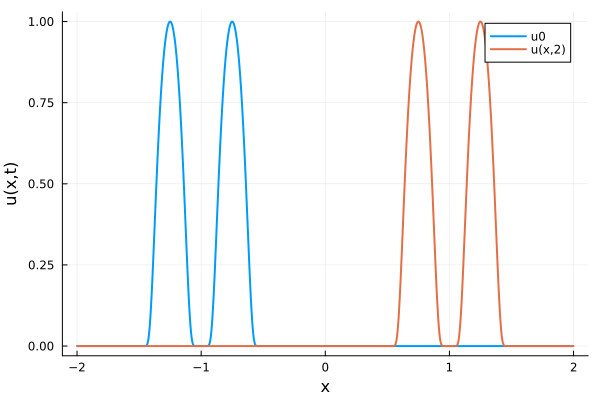

In [6]:
J = 1000
x = discretisation(J)

u1 = u_init.(x)
u2 = u_ex.(x, 2)
plot(xlabel="x", ylabel="u(x,t)")
plot!(x, u1,  label="u0", linewidth=2)
plot!(x, u2,  label="u(x,2)", linewidth=2)

### 1.2. Schéma upwind

On pose $\beta = \Delta t / \Delta x$ et on écrit le schéma sous la forme
$$
\begin{cases}
u_j^{n+1} = u_j^n - \beta (u_j^n - u_{j-1}), & j \in \{1, ..., J\} \\
u_0^n = u_1^n .
\end{cases}
$$

**1.2.a)** *Au brouillon :* Pour quelles valeurs de $j \in \{1, ..., J\}$ est-ce que $u_0$ apparaît dans l'équation ? Réécrire le système pour faire disparaître cette variable artificielle $u_0$.

**1.2.b)** Déterminer la matrice $D$ telle que ce nouveau système prenne la forme $U^{n+1} = U^n - \beta D U^n$. Implémenter une fonction `transport_matrix` qui construit la matrice $D$ à partir du nombre de points `J`.

In [7]:
function transport_matrix(J)
  dv = fill(1.0, J)
  ev = fill(-1.0, J-1)
  return Bidiagonal(dv, ev, :L)
end

transport_matrix (generic function with 1 method)

**1.2.c)** Écrire une fonction `simulate_advec` qui prend en entrée un *vecteur* `u0`, un maillage `x` supposé uniforme, un temps final `T` et un nombre de pas de temps `N`, et qui calcule une solution numérique à ce temps final.

In [8]:

function upwind_loop!(u, u_tmp, S, Nt)
  for _ in 1:Nt
      mul!(u_tmp, S, u)
      u .= u_tmp
  end
end

function simulate_adv(u0, x, T, N)
  # initialisation du maillage et du pas de temps
  dx = x[2] - x[1]
  dt = T / N 
  beta = dt / dx # CFL
  # condition initiale
  U = u0.(x)
  u_tmp = similar(U)

  # initialisation de la matrice de discrétisation
  S = (I - beta * transport_matrix(J))
  # calcul de la solution
  upwind_loop!(U, u_tmp, S, N)

  return  U        
end;

1.2.d) Tracer les solutions numériques obtenues à un temps $T = 2$ sur un maillage de 1000 points avec $1000$ et $10^4$ pas de temps, et comparer à la solution exacte.

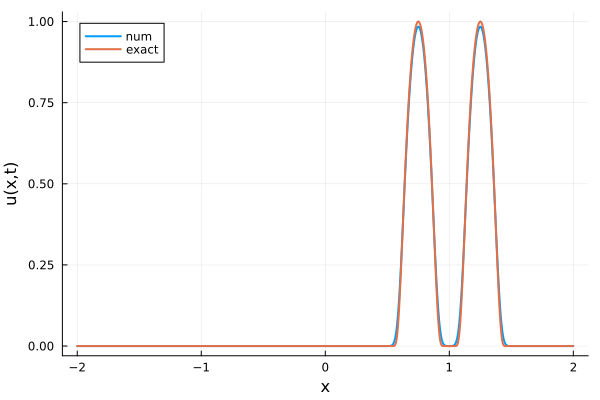

In [26]:
T = 2
# J = 1000
J = 10000 # better
N = 1e4

x = discretisation(J)
u1 = simulate_adv(u_init, x, T, N)
u2 = u_ex.(x, T)

plot(xlabel="x", ylabel="u(x,t)")
plot!(x, u1,  label="num", linewidth=2)
plot!(x, u2,  label="exact", linewidth=2)

## 2/ Problème d'advection-diffusion

Pour ce problème, on considère un $\theta$-schéma sur la diffusion, et un schéma upwind sur l'advection, i.e. pour $j \in \{1, ..., J\}$, 
$$
\begin{aligned}
\frac{u_j^{n+1} - u_j^n}{\Delta t} + \frac{u_j^n - u_{j-1}^n}{\Delta x} = \frac{\varepsilon}{\Delta x^2} & \left[ \theta \left( u_{j+1}^{n+1} - 2u_j^{n+1} + u_{j-1}^{n+1} \right) \right. \\ & \left. \quad + (1-\theta)\left( u_{j+1}^n - 2u_j^n + u_{j-1}^n \right) \right]
\end{aligned}
$$
avec les conditions au bord $u_0 = u_1, u_{J+1} = u_J$.

### 2.1. Questions préliminaires au brouillon

**2.1.a)** Pour quelles valeurs de $j \in \{1, ..., J\}$ est-ce que les conditions au bord apparaissent dans l'équation ? Réécrire le système pour faire disparaître les variables artificielles $u_0$ et $u_{J+1}$.

**2.1.b)** Déterminer les matrices $D$ et $A$ pour écrire le problème sous la forme
$$
\underbrace{(I + \alpha\theta A)}_{\textstyle S_{\rm imp}}\, U^{n+1} = \underbrace{(I - \beta D - \alpha(1-\theta) A)}_{\textstyle S_{\rm exp}}\, U^n . \tag{$\star$}
$$
avec $\alpha = \varepsilon \Delta t / \Delta x^2$ et $\beta = \Delta t / \Delta x$.

### 2.2. Matrices tridiagonales

On rappelle que si une matrice $M$ est tridiagonale et inversible, alors les matrices $L$ et $U$ dans sa décomposition LU sont bidiagonales. Spécifiquement, si on écrit
$$
M = \begin{pmatrix} a_1 & c_1 \\ b_1 & a_2 & c_2 \\ \\ & \ddots & \ddots & \ddots \\ \\ & & b_{n-2} & a_{n-1} & c_{n-1} \\ & & & b_{n-1} & a_n \end{pmatrix}
$$
$$
\text{alors}\qquad 
L = \begin{pmatrix} 1 \\ \lambda_1 & 1 \\ & \ddots & \ddots \\ & & \lambda_{n-1} & 1 \end{pmatrix}
\quad\text{et}\quad
U = \begin{pmatrix} \alpha_1 & \beta_1 \\ & \ddots & \ddots \\ & & \alpha_{n-1} & \beta_{n-1} \\ & & & \alpha_n \end{pmatrix}
$$
avec la relation de récurrence $\alpha_1 = a_1$, pour $k \in \{1, ..., n-1\}$,
$$
\begin{cases}
\lambda_k = b_k / \alpha_k, \\
\beta_k = c_k, \\
\alpha_{k+1} = a_{k+1} - \lambda_k \beta_k
\end{cases}
$$

In [10]:
struct TridiagLU
    lower :: Vector{Float64}
    diag :: Vector{Float64}
    upper :: Vector{Float64}
end
  
"Initialisation de la mémoire pour une factorisation n×n"
TridiagLU(n::Int64) = TridiagLU(zeros(n-1), zeros(n), zeros(n-1))
Base.size(A::TridiagLU) = (length(A.diag), length(A.diag))

**2.2.a)** Remplir cette fonction `TridiagLU` qui initialise la structure à partir d'une matrice `Tridiagonal`.

In [11]:
function factorize!(LU::TridiagLU, A::AbstractMatrix)
  n = size(A, 1)
  lower, diag, upper = zeros(n-1), zeros(n), zeros(n-1)
  LU.diag[1] = A[1, 1]
  for i in 2:n
    LU.lower[i-1] = A[i, i-1] / LU.diag[i-1]
    LU.upper[i-1] = A[i-1, i]
    LU.diag[i] = A[i, i] - LU.lower[i-1] * LU.upper[i-1]
  end
  return LU
end

function TridiagLU(A::AbstractMatrix)
  LU = TridiagLU(size(A, 1)) # on initialise la mémoire
  factorize!(LU, A) # on effectue la factorisation
end

TridiagLU

**2.2.b)** Définir une fonction `solve!` telle que `solve!(x, LU, b, y)` résout le système $LUx = b$ en utilisant la variable d'allocation temporaire $y$ et sans faire d'allocation.

In [12]:
"""
    solve!(x::V, LU::TridiagLU, b::V, y::V) where {V <: Vector{Float64}}

Résout le système `LU*x = b` en modifiant `x` "in-place", avec un stockage temporaire dans `y`.
"""
function _solve_l!(y, LU, b)
    n = length(y)
    y[1] = b[1]
    @inbounds for i in 2:n
        y[i] = b[i] - LU.lower[i-1] * y[i-1]
    end
    return y 
end
  
function _solve_u!(x, LU, y)
    n = length(x)
    x[n] = y[n] / LU.diag[n]
    @inbounds for i in reverse(1:n-1)
        x[i] = (y[i] - LU.upper[i] * x[i+1]) / LU.diag[i]
    end
    return x 
end

function solve!(x::V, LU::TridiagLU, b::V) where {V <: Vector{Float64}}
    _solve_l!(x, LU, b)
    _solve_u!(x, LU, x)
    return x
end

solve! (generic function with 1 method)

**2.2.c)** Faire tourner le test suivant pour valider les fonctions précédentes.

In [13]:
err = 0.0
dim, nb_test = 5, 100
y = zeros(dim)

for _ in 1:nb_test
    M = Tridiagonal(randn(dim, dim))
    factM = TridiagLU(M)
    x = randn(dim)
    solve!(y, factM, x)
    err += norm(M*y - x)
end

@assert (abs(err/nb_test) ≤ 1e-13) "Erreur moyenne > 10^-13 D:"

### 2.3. Simulation d'advection diffusion

**2.3.a)** Implémenter une fonction `poisson_matrix` qui initialise la matrice $A$ dans $(\star)$ à partir du nombre de points de discrétisation `J`.

In [14]:
function poisson_matrix!(J)
  dl = fill(-1.0, J-1)
  d = fill(2.0, J)
  du = fill(-1.0, J-1)

  d[1] = 1
  d[J] = 1

  return Tridiagonal(dl, d, du)
end
 
P = poisson_matrix!(5)

5×5 Tridiagonal{Float64, Vector{Float64}}:
  1.0  -1.0    ⋅     ⋅     ⋅ 
 -1.0   2.0  -1.0    ⋅     ⋅ 
   ⋅   -1.0   2.0  -1.0    ⋅ 
   ⋅     ⋅   -1.0   2.0  -1.0
   ⋅     ⋅     ⋅   -1.0   1.0

**2.3.b)** Écrire une fonction `simulate_advec_diff` qui prend en entrée un *vecteur* `u0`, un maillage `x` supposé uniforme, un temps final `T`, un nombre de pas de temps `N` et deux paramètres `ε` (ou `eps`) et `θ` (ou `theta`), et qui calcule une solution numérique à ce temps final.

In [61]:
function simulate_advec_diff(u0::Function, x::Vector{Float64}, T::Float64, N::Int64, eps::Float64, theta=0.5)
  dx = x[2] - x[1]
  dt = T/N
  Nx = length(x)
  A = poisson_matrix!(Nx)
  beta = dt/dx
  alpha = eps * dt/dx^2

  "conditions initiales"
  U = u0.(x)

  D = transport_matrix(Nx)
  A_ = (I + alpha * theta * A ) # A_ = nom de variable un peu pourri
  B = (I - beta * D - alpha * (1 - theta) * A )
  LU = TridiagLU(A_) 
  # C = A_^-1 * B

  b = similar(x)

  "on resoud A_U^{n+1} = BU, ie LU*U^{n+1} = BU"
  for t in 1:N
    mul!(b, B, U) # b = BU
    solve!(U, LU, b) # LU*U = b
  end
  
  return U
end

simulate_advec_diff (generic function with 2 methods)

**2.3.c)** Calculer une solution numérique avec $T = 2$, $\varepsilon = 10^{-2}$, $\theta = 1/2$, $N = 1000$ et $J = 500$. On devrait obtenir une solution centrée en $x = 1$ où les deux pics initiaux ont *presque* fusionné en un seul.

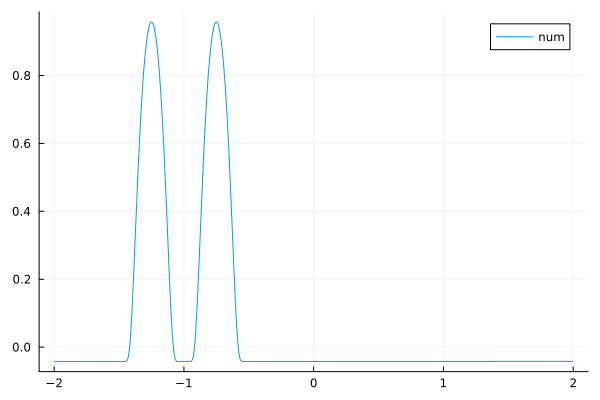

In [66]:
T = 2.
eps = 1e10-2
theta = 0.5
N = 1000
J = 500
x = discretisation(J) 

u = simulate_advec_diff(u_init, x, T, N, eps, theta)

plot(x, u, label="num")

## 3/ Lien entre les problèmes

**3.a)** Simuler le problème d'avection pure avec $J = 500$ et $N = 10^5$. On note $\Delta x$ le pas de maillage.

**3.b)** Simuler le problème d'advection-diffusion avec $J = 5000$ (on peut dénoter $\delta x$ le pas de maillage), $N = 10^5$, $\varepsilon = \Delta x / 2$ et $\theta = 1/2$.

**3.c)** Tracer la solution exacte du problème d'advection pure, et les deux solutions numériques précédentes.